In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from osgeo import gdal
import subprocess
import re
plt.style.use('ggplot')

left, right, bot, top = -119.34, -116.77, 33.06, 35.14

In [5]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
lons = [120, 119, 118, 117]
lats = [36, 35, 34]
arrs = [[None] * len(lons) for _ in range(len(lats))]
for i in range(len(lats)):
    for j in range(len(lons)):
        raster = gdal.Open(f'USGS_13_n{lats[i]}w{lons[j]}.tif')
        geotransform = raster.GetGeoTransform()
        originX = geotransform[0]  # Left upper corner
        pixelWidth = geotransform[1]
        pixelRotateX = geotransform[2]  # Rotation
        originY = geotransform[3]
        pixelRotateY = geotransform[4]  # Rotation
        pixelHeight = geotransform[5]
        band = raster.GetRasterBand(1)
        #print(f"Geotransform information: {geotransform}")

        arr = np.array(band.ReadAsArray())
        #arr[arr<-200] = -200
        nx, ny = arr.shape
        lat = np.arange(ny) * pixelHeight + originY
        lon = np.arange(nx) * pixelWidth + originX

        print(f"Shape of arr: {nx}, {ny}")
        print(f"Min elev = {np.min(arr)}, Max elev = {np.max(arr)}")

        id_lat = np.argwhere(np.logical_and(bot<=lat, lat<=top + 1e-5))
        id_lon = np.argwhere(np.logical_and(left - 1e-5<=lon, lon<=right))
        arrs[i][j] = arr[id_lat[0][0]: id_lat[-1][0], id_lon[0][0] : id_lon[-1][0]]
        print(f"Shape of cropped arr: {np.shape(arrs[i][j])}")

Shape of arr: 10812, 10812
Min elev = -9999.0, Max elev = 2443.4365234375
Shape of cropped arr: (9941, 9401)
Shape of arr: 10812, 10812
Min elev = 53.8399772644043, Max elev = 3068.190185546875
Shape of cropped arr: (9941, 10811)
Shape of arr: 10812, 10812
Min elev = 274.0888671875, Max elev = 3503.6142578125
Shape of cropped arr: (9941, 2814)
Shape of arr: 10812, 10812
Min elev = -9999.0, Max elev = 640.6234741210938
Shape of cropped arr: (8861, 9401)
Shape of arr: 10812, 10812
Min elev = -9999.0, Max elev = 1731.7445068359375
Shape of cropped arr: (8861, 10811)
Shape of arr: 10812, 10812
Min elev = -70.34076690673828, Max elev = 3291.50390625
Shape of cropped arr: (8861, 2814)


In [11]:
for i in range(len(lats)):
    for j in range(len(lons)):
    
        print(arrs[i][j].shape)

(9941, 9401)
(9941, 10811)
(9941, 2814)
(8861, 9401)
(8861, 10811)
(8861, 2814)


In [25]:
plt.imshow(dem[9800:10100, 9250:9550])
plt.show()

In [12]:
dem = np.vstack(tuple(np.hstack( \
        tuple(arrs[i][j][6:-6,6:-6] for j in range(len(lons))) \
        )for i in range(len(lats))))

(18778, 22990)


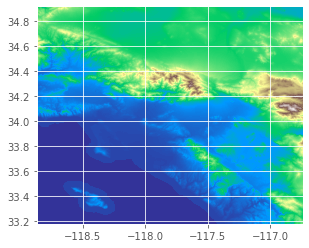

In [13]:
print(dem.shape)
plt.imshow(dem[::50, ::50], cmap='terrain', 
           extent=[left, right, bot, top], vmin=-100, )

In [15]:
head = np.array(dem.shape + (left, right, bot, top))
np.savetxt('DEM_LaHabra_extlarge_0.33sec.txt', head)

In [14]:
dem.astype('float32').tofile('DEM_LaHabra_extlarge_0.33sec.bin')

In [17]:
dem2 = np.fromfile('DEM_LaHabra_extlarge_0.33sec.bin', dtype='float32').reshape(22452, 27745)
plt.imshow(dem2[::50, ::50], cmap='terrain', 
           extent=[left, right, bot, top], vmin=-100, )
plt.colorbar()

648
-118.36 648


Text(0, 0.5, 'Elevation (m)')

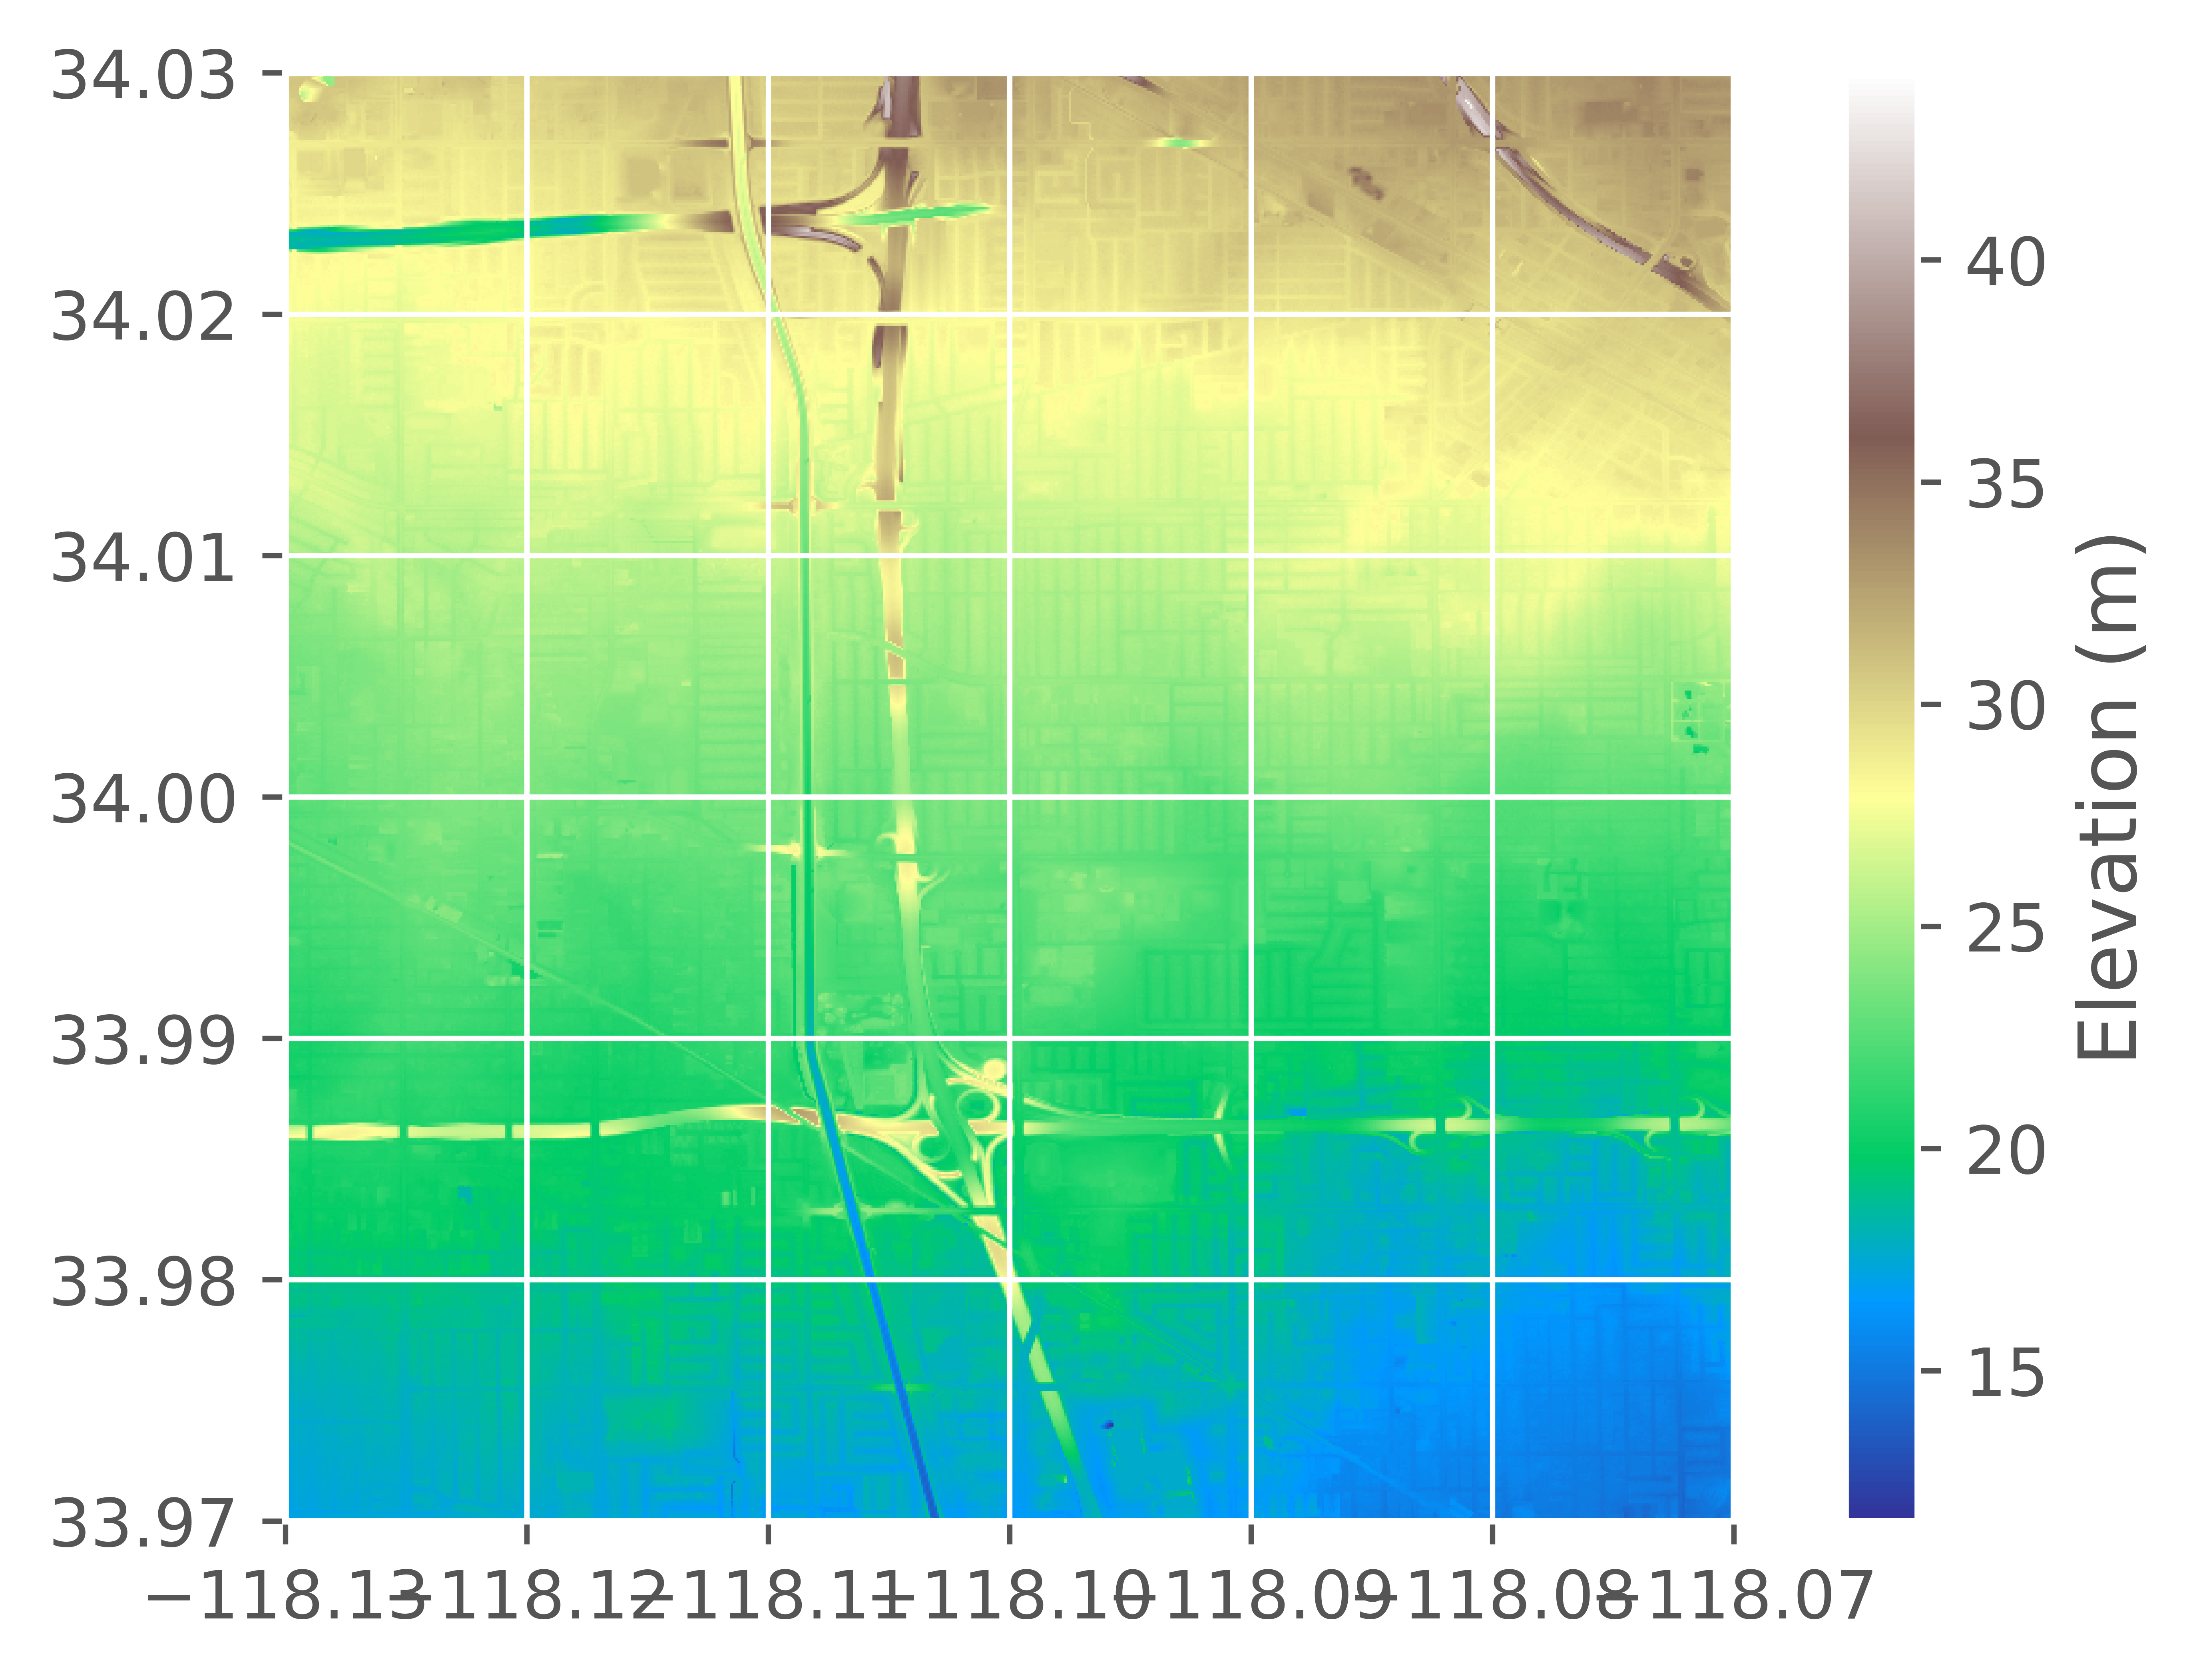

In [9]:
%matplotlib inline
fig, ax = plt.subplots(dpi=600)
id_lat = np.argwhere(np.logical_and(lat>33.97, lat<34.03))
id_lon = np.argwhere(np.logical_and(lon>-118.13, lon<-118.07))
print(len(id_lat))
print(np.min(lon), len(id_lon))
plt.imshow(dem[id_lat[0][0]: id_lat[-1][0], id_lon[0][0] : id_lon[-1][0]], cmap='terrain', 
           extent=[-118.13, -118.07, 33.97, 34.03])
cb = plt.colorbar()
cb.ax.set_ylabel('Elevation (m)')

In [4]:
p = subprocess.Popen('grep -hnr "_Bounding_Coordinate" USGS_NED_13_n34w118_IMG_meta.txt | cut -d ":" -f 3', shell=True,
                stdout=subprocess.PIPE)
y = p.stdout.readlines()
west, east, north, south = (float(re.findall(r'-*\d+.\d+', x.decode('UTF-8'))[0]) for x in y)
print(west, east, north, south)
with open('USGS_NED_13_n34w117_IMG_meta.txt', 'r') as fh:
    lines = fh.readlines()
    matched_lines = [line for line in lines if "Row_Count" in line]
    nx = int(re.findall(r'\d+', matched_lines[0])[0])
    matched_lines = [line for line in lines if "Column_Count" in line]
    ny = int(re.findall(r'\d+', matched_lines[0])[0])
print(f"nx = {nx}, ny = {ny}")

-118.000555556 -116.999444444 34.0005555558 32.9994444436
nx = 10812, ny = 10812
